# A Python tutorial on validating gVirtualXRay

## Import packages

In [1]:
%matplotlib inline

import os # Locate files

import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

from skimage.util import compare_images # Checkboard comparison between two images

import SimpleITK as sitk # Load/Write MHA/MHD files

import viewscad # Use OpenSCAD to create STL files

import pyvista as pv # 3D visualisation
from pyvista import themes

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-06-21T10:07:52) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-06-21T10:07:46) [Compiler: GNU g++] on Linux


## Reference image

We first load the reference image that has been simulated using Gate wrapper for CERN's Geant4.

In [2]:
gate_image = sitk.GetArrayFromImage(sitk.ReadImage("../Gate/output/energy.mhd"))[0];

It is then normalised using the zero-mean, unit variance normalisation method.

In [3]:
gate_image = (gate_image - np.mean(gate_image)) / np.std(gate_image);

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [4]:
json2gvxr.initGVXR("simulation.json", "OPENGL");

Create an OpenGL context: 800x450


We create an X-ray source. It is a point source.

In [5]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: PointSource


The beam spectrum is generated using [SpekPy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home). We decided to use a beam that is clinically appropriate. The chest phantom we used corresponds to a 70kg male patient. For a male chest x-ray, the tube voltage is in the range 80-120kV depending on technique, pathology and equipment used. The total aluminium equivalent filtration is approximately 3.2mm. `verbose=1` below is used to output the beam spectrum for Gate. To disable it, change it to `verbose=0`.

In [6]:
spectrum, unit = json2gvxr.initSpectrum(verbose=1);

/gate/source/mybeam/gps/emin 11.0 keV
/gate/source/mybeam/gps/emax 90.0 keV
/gate/source/mybeam/gps/histpoint 0.011 3
/gate/source/mybeam/gps/histpoint 0.0115 12
/gate/source/mybeam/gps/histpoint 0.012 40
/gate/source/mybeam/gps/histpoint 0.0125 148
/gate/source/mybeam/gps/histpoint 0.013 519
/gate/source/mybeam/gps/histpoint 0.0135 1565
/gate/source/mybeam/gps/histpoint 0.014 4090
/gate/source/mybeam/gps/histpoint 0.0145 9474
/gate/source/mybeam/gps/histpoint 0.015 19789
/gate/source/mybeam/gps/histpoint 0.0155 37826
/gate/source/mybeam/gps/histpoint 0.016 67047
/gate/source/mybeam/gps/histpoint 0.0165 111380
/gate/source/mybeam/gps/histpoint 0.017 174907
/gate/source/mybeam/gps/histpoint 0.0175 261254
/gate/source/mybeam/gps/histpoint 0.018 373324
/gate/source/mybeam/gps/histpoint 0.0185 513706
/gate/source/mybeam/gps/histpoint 0.019 684248
/gate/source/mybeam/gps/histpoint 0.0195 885574
/gate/source/mybeam/gps/histpoint 0.02 1116396
/gate/source/mybeam/gps/histpoint 0.0205 1374186
/

In [7]:
print("kvp:", json2gvxr.params["Source"]["Beam"]["kvp"]);
print("filter material:", json2gvxr.params["Source"]["Beam"]["filter"][0]);
print("filter thickness (in mm):", json2gvxr.params["Source"]["Beam"]["filter"][1]); 

kvp: 90
filter material: Al
filter thickness (in mm): 3.2


Plot the spectrum

Text(0.5, 1.0, 'X-ray spectrum')

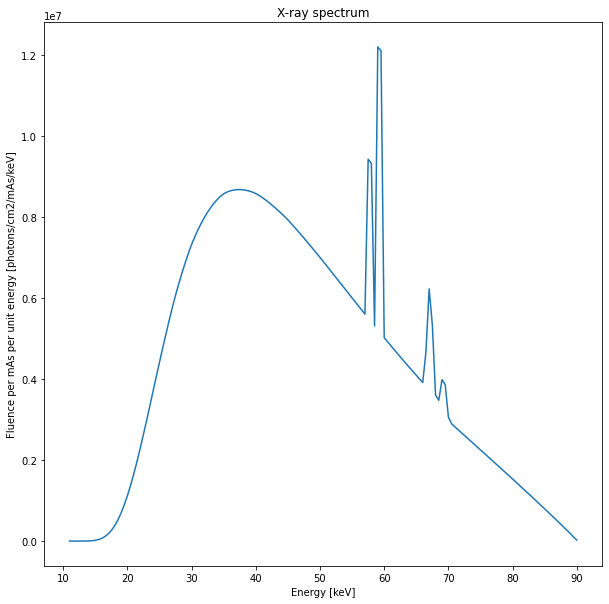

In [8]:
energy_set = sorted(spectrum.keys())
count_set = [];

for energy in energy_set:
    count_set.append(spectrum[energy])
    
plt.figure(figsize= (10,10))
plt.plot(energy_set, count_set) # Plot the spectrum
plt.xlabel('Energy [keV]')
plt.ylabel('Fluence per mAs per unit energy [photons/cm2/mAs/keV]')
plt.title('X-ray spectrum')

Create a digital detector

In [9]:
json2gvxr.initDetector();

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.29296875, 0.29296875, 'mm']


We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files

In [10]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fa=5, $fs=0.1);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [11]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [12]:
r = viewscad.Renderer()
r.render(openscad_matrix_str + openscad_make_spheres_str, outfile='matrix.stl')

In [13]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [14]:
r = viewscad.Renderer()
r.render(openscad_cube_str, outfile='cube.stl')

The spheres

In [15]:
openscad_col_str_set = [];

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");");
        
    r = viewscad.Renderer()
    r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile='col_' + str(i) + '.stl')

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [16]:
json2gvxr.initSamples(verbose=2);

Load the 3D data

Bone_Cortical_ICRU_44: d=1.92 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.034
        +el: name=Carbon ; f=0.155
        +el: name=Nitrogen ; f=0.042
        +el: name=Oxygen ; f=0.435
        +el: name=Sodium ; f=0.001
        +el: name=Magnesium ; f=0.002
        +el: name=Phosphor ; f=0.103
        +el: name=Sulfur ; f=0.003
        +el: name=Calcium ; f=0.225

Blood_Whole_ICRU_44: d=1.06 g/cm3 ; n=10 ; state=solid
        +el: name=Hydrogen ; f=0.102
        +el: name=Carbon ; f=0.11
        +el: name=Nitrogen ; f=0.033
        +el: name=Oxygen ; f=0.745
        +el: name=Sodium ; f=0.001
        +el: name=Phosphor ; f=0.001
        +el: name=Sulfur ; f=0.002
        +el: name=Chlorine ; f=0.003
        +el: name=Potassium ; f=0.002
        +el: name=Iron ; f=0.001

Brain_Grey_White_Matter_ICRU_44: d=1.04 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.107
        +el: name=Carbon ; f=0.145
        +el: name=Nitrogen ; f=0.022
        +el

## Mass attenuation coefficients

Before computing an X-ray image, we can check that the mass attenuation coefficients are accurate. We downloaded tabulated data from the XCOM database and compare the values with the ones used in gVirtualXRay. We do it for relevant chemical elements from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html):

- [Carbon](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z06.html)
- [Chlorine](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z17.html)
- [Hydrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z01.html)
- [Iron](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z26.html)
- [Magnesium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z12.html)
- [Nitrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z07.html)
- [Oxygen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z08.html)
- [Phosphorus](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z15.html)
- [Potassium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z19.html)
- [Sodium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z11.html)
- [Sulfur](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z16.html)

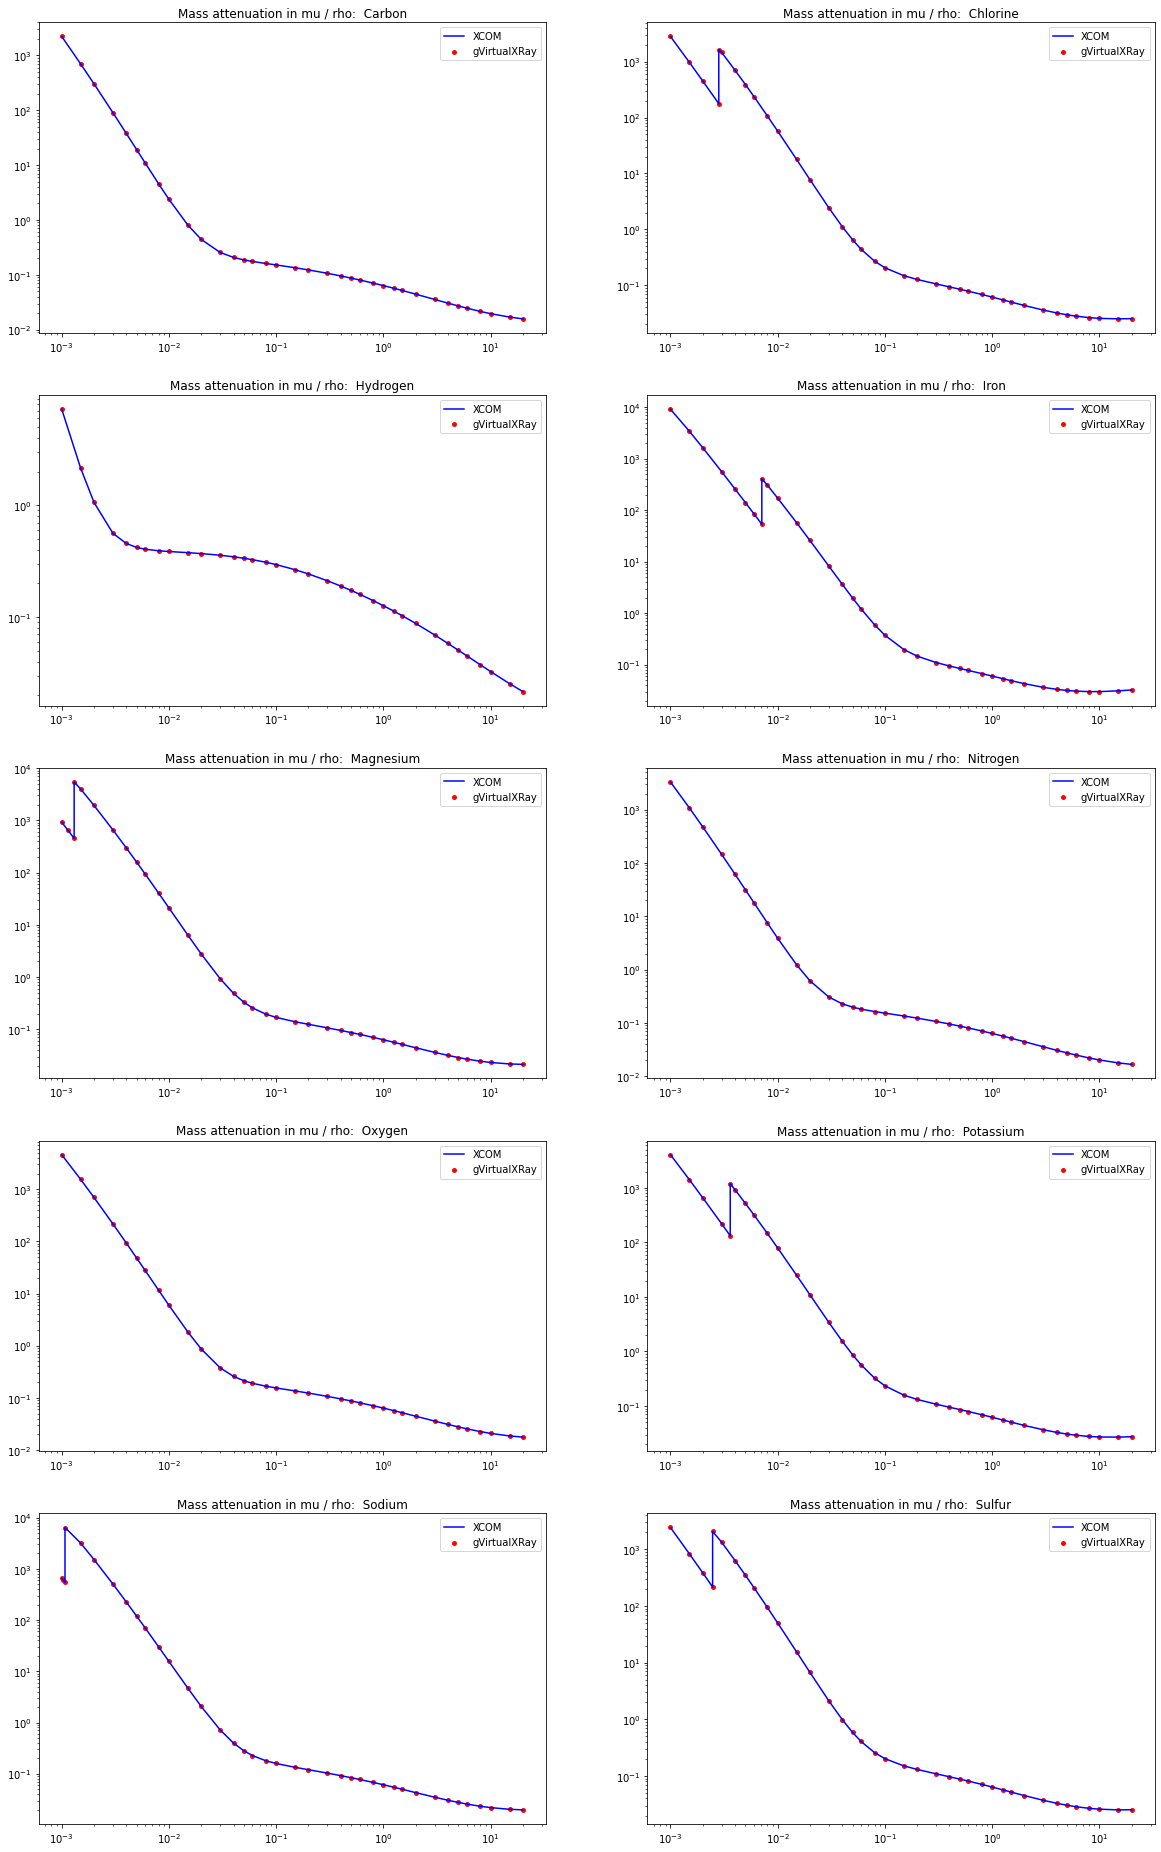

In [17]:
elements = ["Carbon", "Chlorine", "Hydrogen", "Iron", "Magnesium", "Nitrogen", "Oxygen", "Potassium", "Sodium", "Sulfur"] #  "Phosphorus"]#, ];

i = 1

plt.figure(figsize= (20,40))

for element in elements:
    if os.path.isfile("../data/" + element + ".csv"):
        df = pd.read_csv("../data/" + element + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []
        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]
            
            gvxr_mu_rho.append(gvxr.getMassAttenuationFromElement(element, energy, "MeV"))
            gvxr_energy.append(energy)
        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        if df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())
        
        df.to_csv("../data/" + element + "-validation.csv", index=False )
        
        plt.subplot(6, 2, i)
        plt.title("Mass attenuation in mu / rho:  " + element)
        plt.plot(df["Photon in MeV"], df["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(gvxr_energy, gvxr_mu_rho, label="gVirtualXRay", s=15, color="r")
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        i = i + 1

And for some clinically relevant materials from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html):

- [Adipose Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/adipose.html)
- [Blood, Whole (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/blood.html)
- [Bone, Cortical (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html)
- [Brain, Grey/White Matter (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/brain.html)
- [Breast Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/breast.html)
- [Water, Liquid](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html)

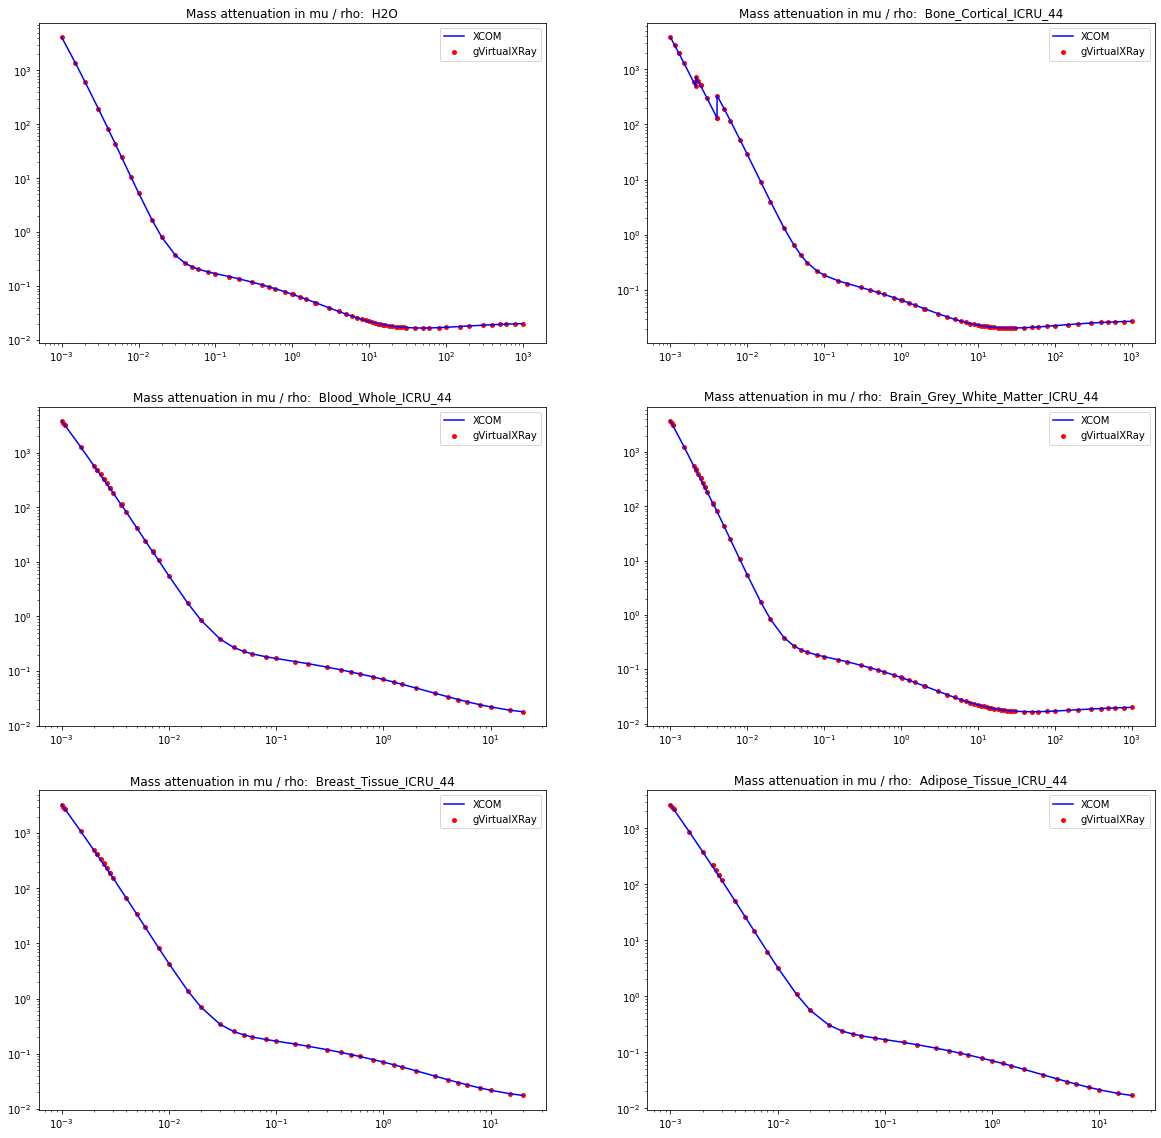

In [18]:
i = 1

plt.figure(figsize= (20,20))
for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    if os.path.isfile("../data/" + label + ".csv"):
        df = pd.read_csv("../data/" + label + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []

        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]

            gvxr_mu_rho.append(gvxr.getMassAttenuationCoefficient(label, energy, "MeV"))
            gvxr_energy.append(energy)

        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        if df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())

        df.to_csv("../data/" + label + "-validation.csv", index=False)
        
        plt.subplot(3, 2, i)
        plt.title("Mass attenuation in mu / rho:  " + label)
        plt.plot(df["Photon in MeV"], df["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(gvxr_energy, gvxr_mu_rho, label="gVirtualXRay", s=15, color="r")
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        i = i + 1

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [19]:
gvxr.displayScene();

gvxr.useLighing();
gvxr.useWireframe();
gvxr.setZoom(719.6787109375);
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0]);

gvxr.displayScene();

In [20]:
screenshot = gvxr.takeScreenshot();

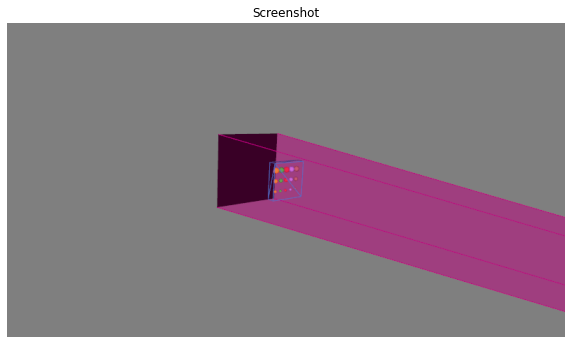

In [21]:
plt.figure(figsize= (10,10))
plt.title("Screenshot");
plt.imshow(screenshot);
plt.axis('off');

Compute an X-ray image and add it to the list of projections

In [22]:
x_ray_image = gvxr.computeXRayImage();

Save the corresponding image

In [23]:
volume = sitk.GetImageFromArray(x_ray_image);
sitk.WriteImage(volume, 'projection.mha');

Normalise the data

In [24]:
x_ray_image = (x_ray_image - np.mean(x_ray_image)) / np.std(x_ray_image);

Interactive 3D visualisation, including the X-ray image displyed on the detector geometry

In [25]:
# %matplotlib widget

# my_theme = themes.DarkTheme()
# my_theme.color = 'red'
# my_theme.lighting = False
# my_theme.show_edges = True
# my_theme.axes.box = True

# pv.global_theme.load_theme(my_theme)

plotter = pv.Plotter(notebook=True, window_size=(512 * 4, 256 * 4))
plotter.add_title("3D Visualisation")
i = 0;

colours = list(mcolors.TABLEAU_COLORS);
colour_id = 0;

# Add the samples
for sample in json2gvxr.params["Samples"]:
   
    if sample["Label"] == "H2O":
        opacity = 0.25;
    else:
        opacity = 1.0;

    mesh = pv.read(sample["Path"])

    colour = mcolors.to_rgb(colours[colour_id]);
    plotter.add_mesh(mesh, opacity=opacity, color=(colour[0], colour[1], colour[2]))
    colour_id += 1

# Add the source
source_position = json2gvxr.params["Source"]["Position"];
source_position = np.array([source_position[0], source_position[1], source_position[2]])

sphere = pv.Sphere(radius=10, center=source_position)
colour = mcolors.to_rgb(colours[colour_id]);
plotter.add_mesh(sphere, color=(colour[0], colour[1], colour[2]))
colour_id += 1

# Add the detector
detector_position = json2gvxr.params["Detector"]["Position"];
detector_position = np.array([detector_position[0], detector_position[1], detector_position[2]])

detector_direction = detector_position - source_position;
plane = pv.Plane(center=detector_position,
                 direction=detector_direction,
                 i_size=json2gvxr.params["Detector"]["Size"][0],
                 j_size=json2gvxr.params["Detector"]["Size"][1],
                 i_resolution=1, j_resolution=1)

# Creating a custom RGBA image
cmap = get_cmap("gray")
norm = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
hue = norm(np.fliplr(x_ray_image.T).ravel())
colors = (cmap(hue) * 255.0).astype(np.uint8)
image = colors.reshape((x_ray_image.shape[0], x_ray_image.shape[1], 4), order="F")

texture = pv.numpy_to_texture(image)
plotter.add_mesh(plane, texture=texture)

cpos = plotter.show(cpos=[(-965.0666772245627, 47.72249675199398, 1249.8218575579394),
                          (0.0, 0.0, 442.5),
                          (0, 1, 0)])

ViewInteractiveWidget(height=1024, layout=Layout(height='auto', width='100%'), width=2048)

In [26]:
plotter.camera_position

[(-965.0666772245627, 47.72249675199398, 1249.8218575579394),
 (0.0, 0.0, 442.5),
 (0.0, 1.0, 0.0)]

Update the 3D visualisation and take a screenshot

In [27]:
gvxr.displayScene();
screenshot = gvxr.takeScreenshot();

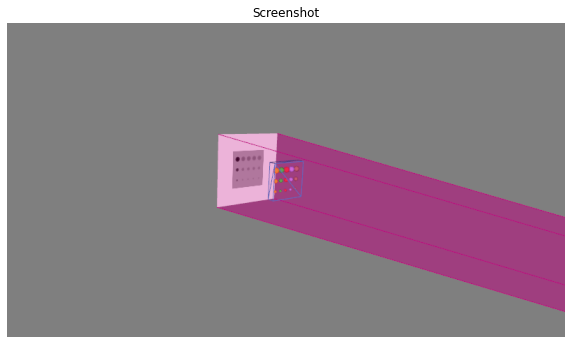

In [28]:
plt.figure(figsize= (10,10))
plt.title("Screenshot");
plt.imshow(screenshot);
plt.axis('off');

Plot the X-ray image

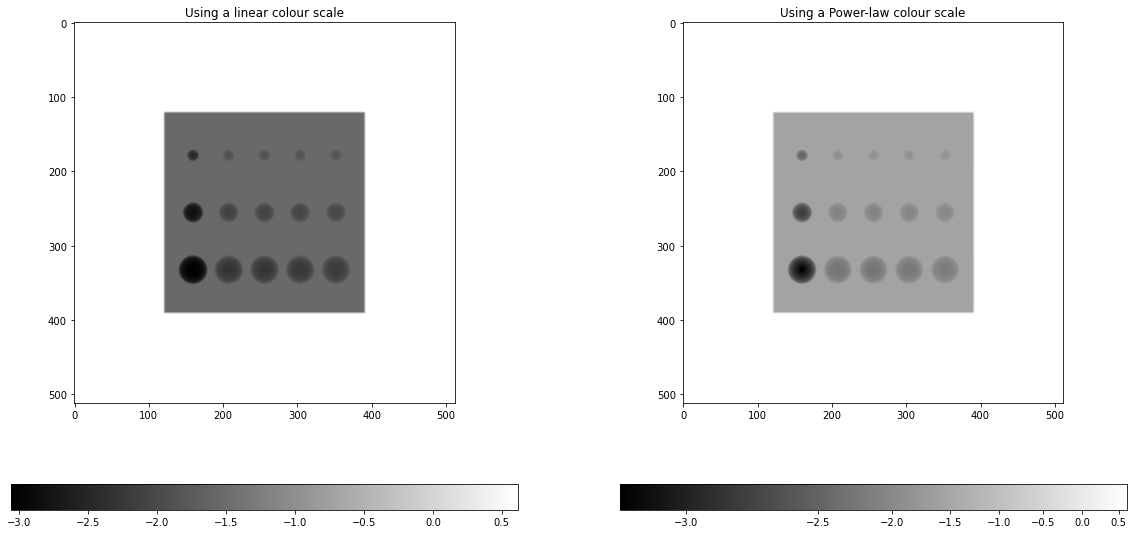

In [29]:
plt.figure(figsize= (20,10))
plt.subplot(121)
plt.imshow(x_ray_image, cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a linear colour scale");

plt.subplot(122)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./2.), cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a Power-law colour scale");

## Compare the analytic simulation with the Monte Carloa simulation

Compute the normalised cross-correlation (ZNCC)

In [30]:
ZNCC = np.mean(gate_image * x_ray_image);
print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

ZNCC: 93.62%


Checkboard comparison

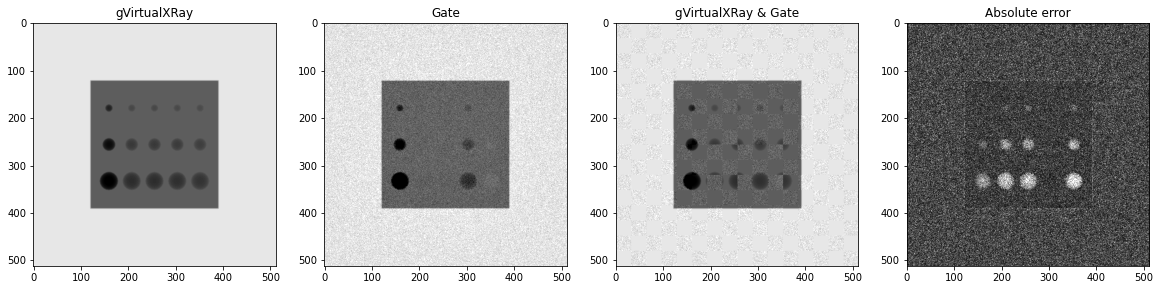

In [31]:
absolute_error = np.abs(gate_image - x_ray_image);
comp_equalized = compare_images(gate_image, x_ray_image, method='checkerboard', n_tiles=(16,16))

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(x_ray_image, cmap="gray", vmin=-3, vmax=1);
plt.title("gVirtualXRay");

plt.subplot(142)
plt.imshow(gate_image, cmap="gray", vmin=-3, vmax=1);
plt.title("Gate");

plt.subplot(143)
plt.imshow(comp_equalized, cmap="gray", vmin=-3, vmax=1);
plt.title("gVirtualXRay & Gate");

plt.subplot(144)
plt.imshow(absolute_error, cmap="gray", vmin=0, vmax=1);
plt.title("Absolute error");

Plot the profiles

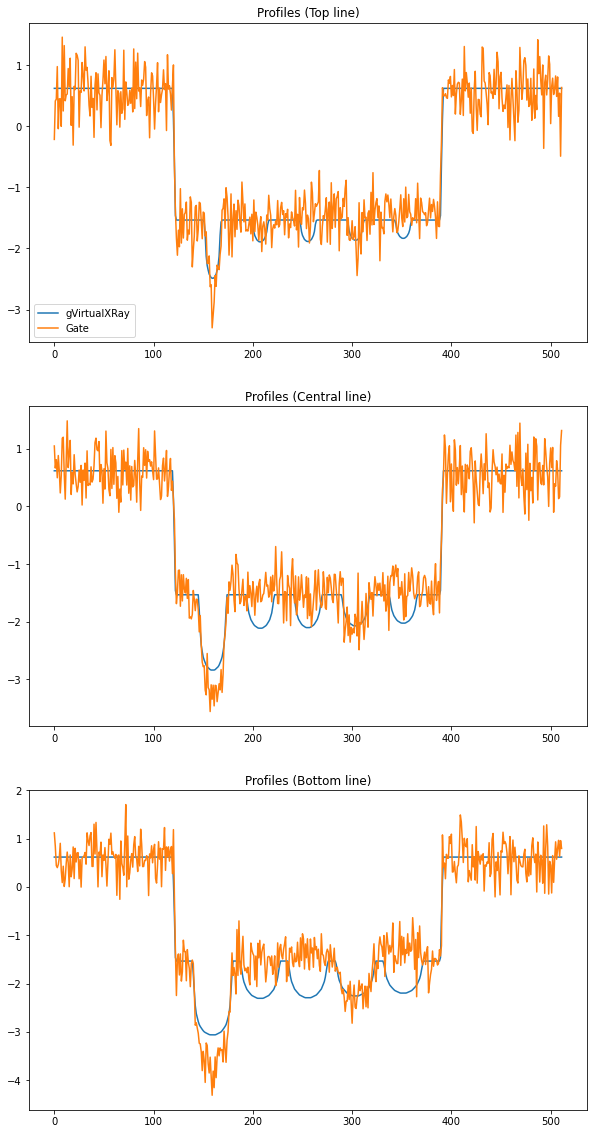

In [32]:
plt.figure(figsize= (10,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

plt.subplot(311)
plt.title("Profiles (Top line)");
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x_ray_image[y_coord], label="gVirtualXRay")
plt.plot(gate_image[y_coord], label="Gate")
plt.legend()

plt.subplot(312)
plt.title("Profiles (Central line)");
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)
plt.plot(x_ray_image[y_coord], label="gVirtualXRay")
plt.plot(gate_image[y_coord], label="Gate")

plt.subplot(313)
plt.title("Profiles (Bottom line)");
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x_ray_image[y_coord], label="gVirtualXRay")
plt.plot(gate_image[y_coord], label="Gate")

Destroy the window

In [33]:
gvxr.destroyAllWindows()